# So we took a look at the data

In [2]:
from typing import Tuple, List

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report

In [3]:
train = pd.read_csv('./propaganda_dataset_v2/propaganda_train.tsv', header=0, quoting=3, sep='\t')
test = pd.read_csv('./propaganda_dataset_v2/propaganda_val.tsv', header=0, quoting=3, sep='\t')

dataset = pd.concat([train, test])

In [4]:
BEGINNING_OF_SPAN = "<BOS>"
END_OF_SPAN = "<EOS>"

def extract_snippet(sample: str) -> str:
    """
    Extract text within the <BOS> and <EOS> tags.

    Args:
        sample (str): A text sample containing both <BOS> and <EOS>

    Returns:
        str: A string with only the text within the span
    """

    assert (
        BEGINNING_OF_SPAN in sample
    ), "Text sample should contain beginning of span tag (<BOS>)"
    assert END_OF_SPAN in sample, "Text sample should contain end of span tag (<EOS>)"
    s_idx = sample.index(BEGINNING_OF_SPAN) + len(BEGINNING_OF_SPAN)
    e_idx = sample.index(END_OF_SPAN)
    return sample[s_idx:e_idx]

In [5]:
propaganda_count = len(dataset[dataset['label'] != 'not_propaganda' ])
propaganda_count

1600

In [6]:
len(train[train['label'] != 'not_propaganda']) / len(train)

0.504296875

In [7]:
len(test[test['label'] != 'not_propaganda']) / len(test)

0.4828125

In [18]:
labels = set(dataset['label'])
labels, len(labels)

({'appeal_to_fear_prejudice',
  'causal_oversimplification',
  'doubt',
  'exaggeration,minimisation',
  'flag_waving',
  'loaded_language',
  'name_calling,labeling',
  'not_propaganda',
  'repetition'},
 9)

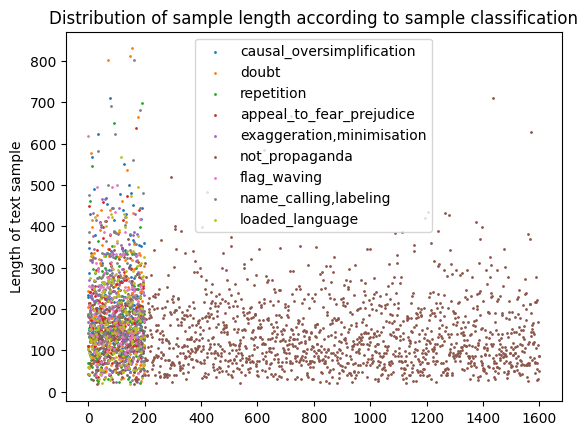

In [9]:
sorted_dataset = {label: list(dataset[dataset['label'] == label]['tagged_in_context']) for label in labels}
extracted_dataset = {label: [extract_snippet(sample) for sample in samples] for label, samples in sorted_dataset.items()}
sample_lengths = {label: [len(text_sample) for text_sample in text_samples] for label, text_samples in sorted_dataset.items()}

for label, lengths in sample_lengths.items():
    plt.scatter(np.arange(0, len(lengths)), lengths, label=label, s=1)

plt.title("Distribution of sample length according to sample classification")
plt.ylabel("Length of text sample")
plt.legend()
plt.show()

# Word Count Metrics

In [17]:
def determine_metrics(samples: List[int]) -> Tuple[float, float, int, int]:
    return np.mean(samples), np.std(samples), np.min(samples), np.max(samples)

for i, (label, samples) in enumerate(extracted_dataset.items()):
    metrics = determine_metrics([len(word_tokenize(sample)) for sample in samples])
    label = label.replace("_", " ").replace(",", ", ").title()
    print(f"\\textbf{{{i + 1}}} & {np.round(metrics[0], decimals=2)} & {np.round(metrics[1], decimals=2)} & {metrics[3] - metrics[2]} \\\\")

\textbf{1} & 23.72 & 14.75 & 87 \\

\textbf{2} & 22.95 & 19.99 & 159 \\

\textbf{3} & 3.14 & 4.08 & 38 \\

\textbf{4} & 19.24 & 13.61 & 79 \\

\textbf{5} & 8.15 & 6.2 & 46 \\

\textbf{6} & 7.26 & 8.01 & 92 \\

\textbf{7} & 12.04 & 13.27 & 78 \\

\textbf{8} & 4.8 & 3.92 & 23 \\

\textbf{9} & 3.72 & 3.7 & 29 \\

## Correlation

In [11]:
data = {
    "Label": [],
    "Mean Word Count": [],
    "Standard Deviation": [],
    "Range": []
}

for label, samples in sorted_dataset.items():
    metrics = determine_metrics([len(word_tokenize(sample)) for sample in samples])
    data['Label'].append(label.replace("_", " ").replace(",", ", ").title())
    data['Mean Word Count'].append(metrics[0])
    data['Standard Deviation'].append(metrics[1])
    data['Range'].append(metrics[3] - metrics[2])

df = pd.DataFrame(data)

# Baselines

## Detection

In [12]:
binary_labels = np.array(dataset['label'].apply(lambda label: 'propaganda' if label != 'not_propaganda' else label))
random_predictions = np.random.choice(['not_propaganda', 'propaganda'], binary_labels.shape)
print(classification_report(binary_labels, random_predictions))

precision    recall  f1-score   support

not_propaganda       0.49      0.48      0.48      1600
    propaganda       0.49      0.50      0.50      1600

      accuracy                           0.49      3200
     macro avg       0.49      0.49      0.49      3200
  weighted avg       0.49      0.49      0.49      3200

## Classification

In [13]:
true_labels = np.array(dataset['label'])
random_predictions = np.random.choice(list(labels), size=true_labels.shape)
print(classification_report(true_labels, random_predictions))

precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.09      0.15      0.11       200
causal_oversimplification       0.06      0.12      0.08       200
                    doubt       0.07      0.12      0.08       200
exaggeration,minimisation       0.08      0.14      0.10       200
              flag_waving       0.04      0.07      0.05       200
          loaded_language       0.07      0.12      0.09       200
    name_calling,labeling       0.06      0.10      0.07       200
           not_propaganda       0.54      0.13      0.21      1600
               repetition       0.07      0.11      0.08       200

                 accuracy                           0.12      3200
                macro avg       0.12      0.12      0.10      3200
             weighted avg       0.30      0.12      0.14      3200

# Results 

In [24]:
classifier_sweep = pd.read_csv('./assets/wandb-classifier-runs.csv')
for i in [np.mean(classifier_sweep['test_accuracy']), np.mean(classifier_sweep['test_f1']), np.mean(classifier_sweep['test_precision']), np.mean(classifier_sweep['test_recall'])]:
    print(np.round(i, decimals=2))

0.46

0.43

0.47

0.46